In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
# Create a directory if it is not there, so we can save files and results in it
from pathlib import Path
Path('/kaggle/working/lstm1d').mkdir(parents=True,exist_ok=True)

In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=293152 sha256=c85de8edcf6982c49ac6e1ca5bda4ea4f2945423ec04503f62799d33b953277a
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee


In [3]:
import numpy as np
import pandas as pd
import math
import os
import random
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import yfinance as yf

In [20]:
def stock_predict_1D(stock_name, filename):
    # Downloading stock data from Yahoo Finance
    stock_data = yf.download(stock_name, start='2019-01-01', end='2024-01-01')
    specific_df = pd.DataFrame(stock_data).reset_index()
    specific_df['Name'] = stock_name

    new_df = specific_df.reset_index()['Close']
    scaler=MinMaxScaler()
    scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

    from sklearn.model_selection import train_test_split
    test_size = 0.2
    train_data, test_data = train_test_split(scaled_data, test_size=test_size, shuffle=False)

    def generate_sequences_and_labels(data, n_past):
        sequences = [data[i - n_past:i, 0] for i in range(n_past, len(data))]
        labels = [data[i, 0] for i in range(n_past, len(data))]
        return np.array(sequences), np.array(labels)

    n_past = 60
    x_train, y_train = generate_sequences_and_labels(train_data, n_past)
    x_test, y_test = generate_sequences_and_labels(test_data, n_past)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
    
    def build_lstm_model(input_shape):
        model = Sequential()
        model.add(LSTM(units=50, input_shape=[x_train.shape[1], 1]))
        model.add(Dense(10))
#         model.add(LSTM(units=25))
        # model.add(Dense(5))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        return model

    def compile_lstm_model(model):
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    def train_lstm_model(model, x_train, y_train, x_test, y_test):
        model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32, verbose=0)

    model = build_lstm_model(x_train.shape[1])
    compile_lstm_model(model)
    train_lstm_model(model, x_train, y_train, x_test, y_test)

    folder_path = "/kaggle/working/lstm1d/"  # Get the current script's directory
    filename_a = folder_path+filename+'_lstm1d.keras'
    model.save(filename_a)

#     folder_path = os.path.dirname(os.path.abspath(__file__))  # Get the current script's directory
#     filename_a = os.path.join(folder_path, filename + "1D.keras")
#     # model.save(filename_a)

#     model = tf.keras.models.load_model(filename_a)

    def make_predictions(model, x_train, x_test):
        train_predict = model.predict(x_train)
        test_predict = model.predict(x_test)
        return train_predict, test_predict

    train_predict, test_predict = make_predictions(model, x_train, x_test)

    def inverse_transform(scaler, y_train, train_predict, y_test, test_predict):
        y_test = y_test.reshape(-1,1)
        y_train = y_train.reshape(-1,1)
        y_test = scaler.inverse_transform(y_test)
        y_train = scaler.inverse_transform(y_train)
        train_predict = scaler.inverse_transform(train_predict)
        test_predict = scaler.inverse_transform(test_predict)
        return y_test, y_train, train_predict, test_predict

    y_test, y_train, train_predict, test_predict = inverse_transform(scaler, y_train, train_predict, y_test, test_predict)

    def evaluate_model(y_train, train_predict, y_test, test_predict):
        #train_mse = mean_squared_error(y_train, train_predict)
        test_mse = mean_squared_error(y_test, test_predict)
        test_mae = mean_absolute_error(y_test, test_predict)
        test_mape = mean_absolute_percentage_error(y_test, test_predict)
        test_rs = r2_score(y_test, test_predict)
        #print(f"Training MSE: {train_mse}")
        print(f"MSE of {stock_name}: {test_mse}")
        print(f"MAE of {stock_name}: {test_mae}")
        print(f"MAPE of {stock_name}: {test_mape}")
        print(f"R Sqaured of {stock_name}: {test_rs}")

    evaluate_model(y_train, train_predict, y_test, test_predict)


    predictions = model.predict(x_test)

    actual_values_inverse = y_test
    predicted_values_inverse = scaler.inverse_transform(predictions)

    # comparison_df = pd.DataFrame({'Actual Close Prices': actual_values_inverse.flatten(), 'Predicted Close Prices': predicted_values_inverse.flatten()})
    # print(comparison_df.head())

    plt.figure(figsize=(10, 5))
    plt.plot(actual_values_inverse.flatten(), label="Actual Close Prices")
    plt.plot(predicted_values_inverse.flatten(), 'r', label="Predicted Close Prices")
    plt.ylabel('Close Price')
    plt.xlabel('Time Step')
    plt.legend()
    plt.title(stock_name+'-LSTM 1D')
    plt_name = folder_path+filename+'_lstm1d.png'
    plt.savefig(plt_name)
    
#     plt.plot(actual_prices, label='Actual')
#     plt.plot(predicted_prices, label='Predicted')
#     plt.title(stockname+'-PSO')
# #     plt.title('Stock Price Prediction using LSTM+PSO')
#     plt.xlabel('Time')
#     plt.ylabel('Stock Price')
#     plt.legend()
#     plt_name = folder_path+filename+'_lstm1d.png'
#     plt.savefig(plt_name)

In [21]:
stock_list = ["AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW","GS","HD","HON",
              "IBM","INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH",
              "V","VZ","WBA","WMT"]
print(len(stock_list))

30


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of AAPL: 21.255775182112604
MAE of AAPL: 4.18369706471761
MAPE of AAPL: 0.02304966160554332
R Sqaured of AAPL: 0.7845781244542264
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of AMGN: 11.961070401744415
MAE of AMGN: 2.547468662261963
MAPE of AMGN: 0.010063668949917096
R Sqaured of AMGN: 0.9710999046362089
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of AXP: 6.658364262709561
MAE of AXP: 1.9971257050832112
MAPE of AXP: 0.012493920945764202
R Sqaured of AXP: 0.9352742678715013
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of BA: 12.2579573498042
MAE of BA: 2.519212007522583
MAPE of BA: 0.011812949438055142
R Sqaured of BA: 0.9669826655886209
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of CAT: 43.790497932324804
MAE of CAT: 5.3055048783620204
MAPE of CAT: 0.02084083424657952
R Sqaured of CAT: 0.9310757928419419
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of CRM: 13.054189227833078
MAE of CRM: 2.6115578810373945
MAPE of CRM: 0.01203873820128046
R Sqaured of CRM: 0.9602514006531727
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of CSCO: 0.5170462524543685
MAE of CSCO: 0.5254852573076884
MAPE of CSCO: 0.010240301231501471
R Sqaured of CSCO: 0.934495225622761
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of CVX: 5.465852567987894
MAE of CVX: 1.7676840623219812
MAPE of CVX: 0.011174845269779318
R Sqaured of CVX: 0.9190331384826982
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of DIS: 2.641803148522134
MAE of DIS: 1.193861722946167
MAPE of DIS: 0.013382320377278592
R Sqaured of DIS: 0.9263018540694953
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of DOW: 0.5519480056122816
MAE of DOW: 0.5735899993727884
MAPE of DOW: 0.010967379105557146
R Sqaured of DOW: 0.8765436894064111
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of GS: 26.81937132953317
MAE of GS: 3.961629549662272
MAPE of GS: 0.011846704076413818
R Sqaured of GS: 0.920335843974921
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of HD: 14.887438304673802
MAE of HD: 2.9333295822143555
MAPE of HD: 0.009646614996380715
R Sqaured of HD: 0.9566046459588715
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of HON: 4.518612386878279
MAE of HON: 1.6088677247365315
MAPE of HON: 0.008311328431597197
R Sqaured of HON: 0.9270408935002328
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of IBM: 4.265480775701687
MAE of IBM: 1.7169186671574905
MAPE of IBM: 0.011956400858146624
R Sqaured of IBM: 0.9657671579540577
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of INTC: 0.8323060526010785
MAE of INTC: 0.7017042338848114
MAPE of INTC: 0.020005663298848893
R Sqaured of INTC: 0.9659076386885759
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of JNJ: 2.9762054622976084
MAE of JNJ: 1.1893101533253987
MAPE of JNJ: 0.007434156052952495
R Sqaured of JNJ: 0.9291012293976976
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of JPM: 3.4586563051179837
MAE of JPM: 1.4344898859659831
MAPE of JPM: 0.009787609772438225
R Sqaured of JPM: 0.9598724451379665
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of KO: 0.2960740339187853
MAE of KO: 0.4053056438763936
MAPE of KO: 0.0068848486482906285
R Sqaured of KO: 0.9625538916510966
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of MCD: 12.651233448366838
MAE of MCD: 3.1225744088490806
MAPE of MCD: 0.011043643532808345
R Sqaured of MCD: 0.9255485727538796
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of MMM: 31.01389932645149
MAE of MMM: 5.398127357165019
MAPE of MMM: 0.06508782801647596
R Sqaured of MMM: -0.2698107114644004
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of MRK: 3.4521648012284145
MAE of MRK: 1.5582169294357293
MAPE of MRK: 0.014320601897590936
R Sqaured of MRK: 0.8359824293121276
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/tmp/ipykernel_34/303382028.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of MSFT: 47.406577239666724
MAE of MSFT: 5.728299140930175
MAPE of MSFT: 0.01712205159390073
R Sqaured of MSFT: 0.9283039287507358
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of NKE: 4.210443274553956
MAE of NKE: 1.4674166043599444
MAPE of NKE: 0.013638339632917001
R Sqaured of NKE: 0.9522945942253501
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of PG: 2.52110688668836
MAE of PG: 1.261065880457561
MAPE of PG: 0.008362537268531601
R Sqaured of PG: 0.8240521821132116
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of TRV: 15.328548266226184
MAE of TRV: 3.441327174504598
MAPE of TRV: 0.019840221560937565
R Sqaured of TRV: 0.7240141909216149
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of UNH: 46.21525664662959
MAE of UNH: 4.858811219533284
MAPE of UNH: 0.009684685243219639
R Sqaured of UNH: 0.9226978513178872
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of V: 5.114788444467802
MAE of V: 1.7427582740783698
MAPE of V: 0.007388406280776523
R Sqaured of V: 0.9501684607527174
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of VZ: 0.8176794038864159
MAE of VZ: 0.7673079868157705
MAPE of VZ: 0.022097241896890146
R Sqaured of VZ: 0.8437124529911344
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of WBA: 0.9735213027340702
MAE of WBA: 0.8292960921923318
MAPE of WBA: 0.03275775980753364
R Sqaured of WBA: 0.9611706475656719
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of WMT: 0.9002707016494845
MAE of WMT: 0.8347302277882891
MAPE of WMT: 0.01591453912542144
R Sqaured of WMT: 0.7144112272872174
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


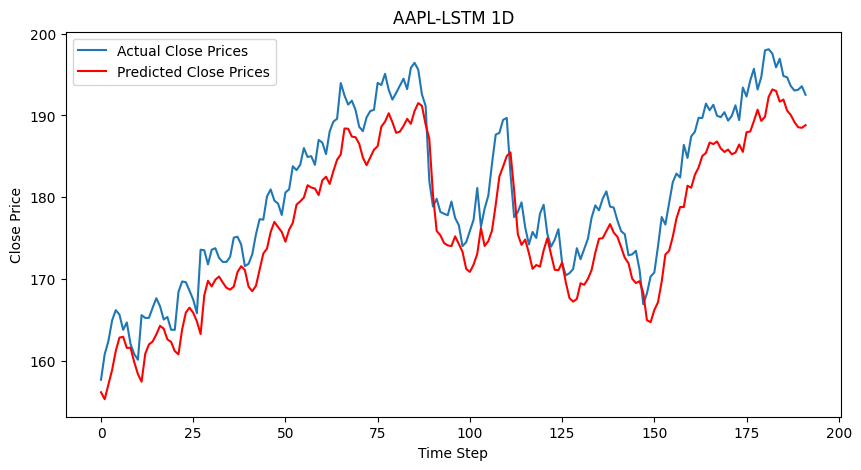

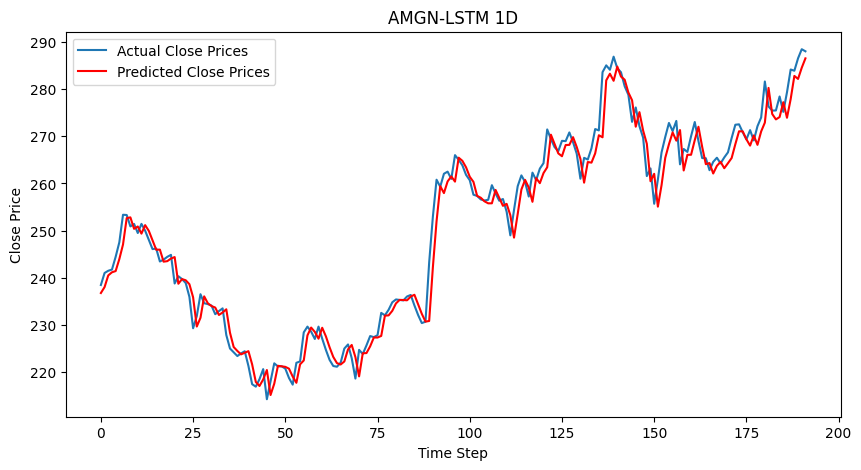

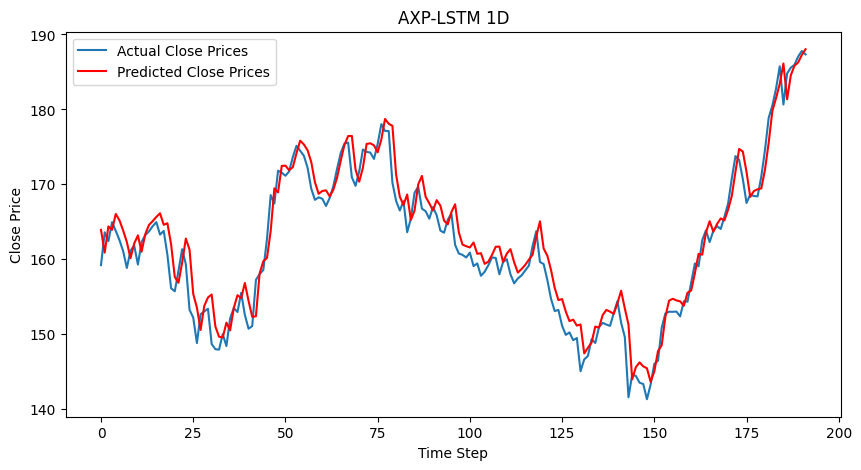

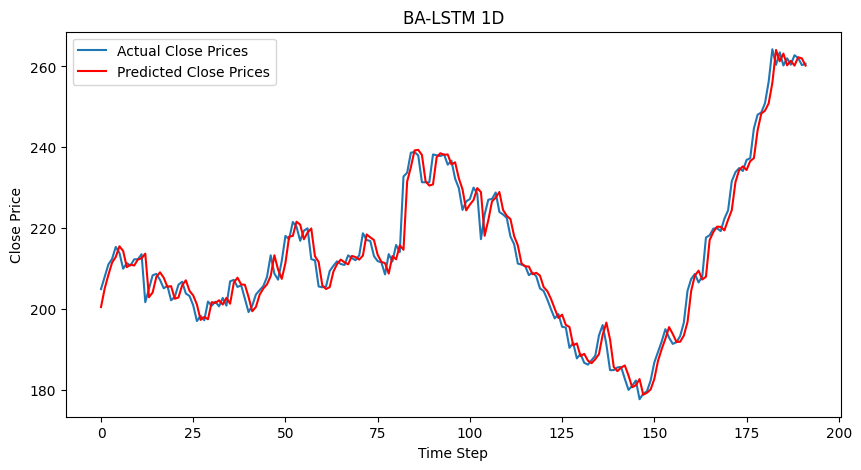

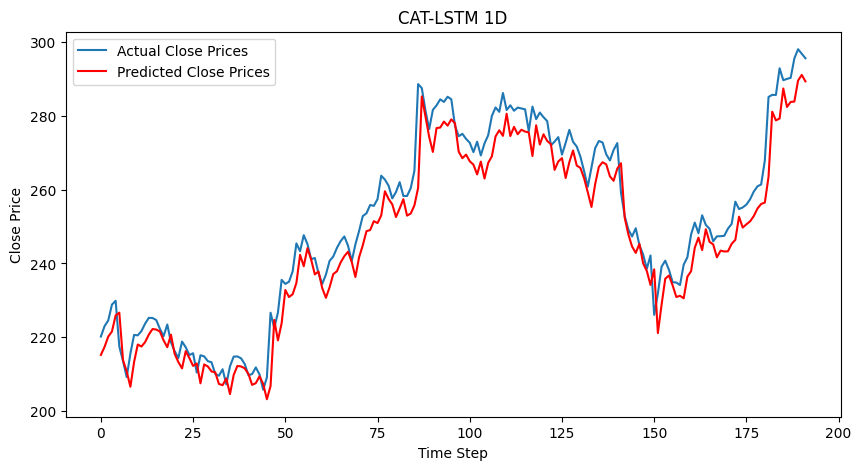

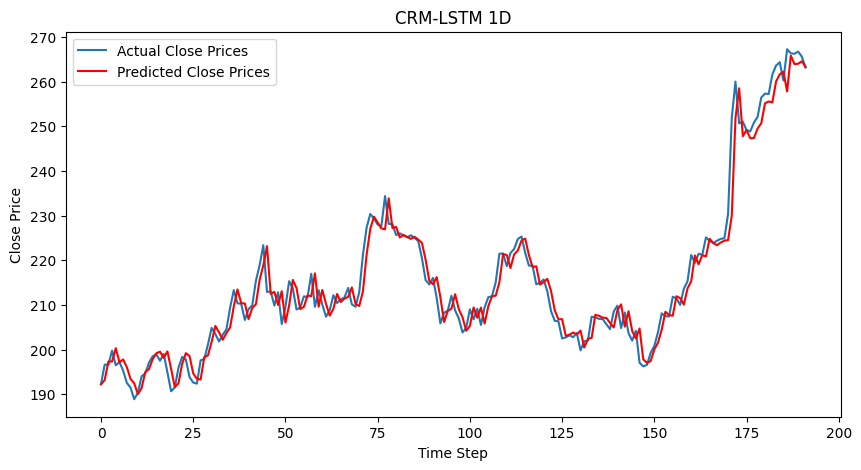

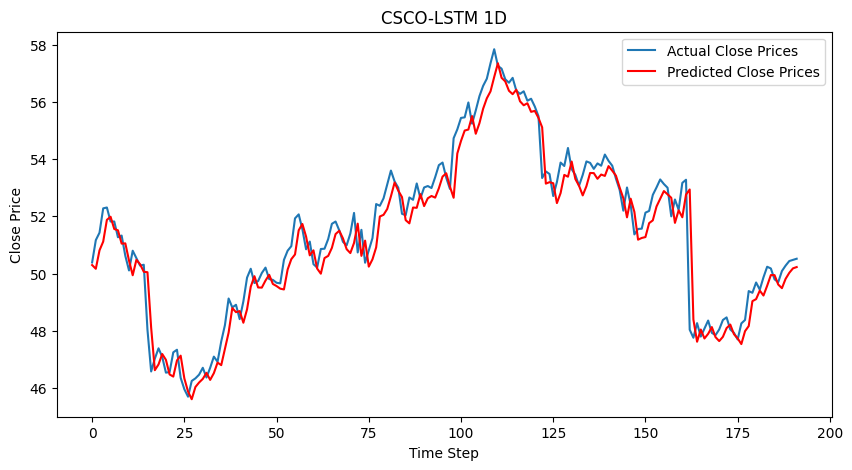

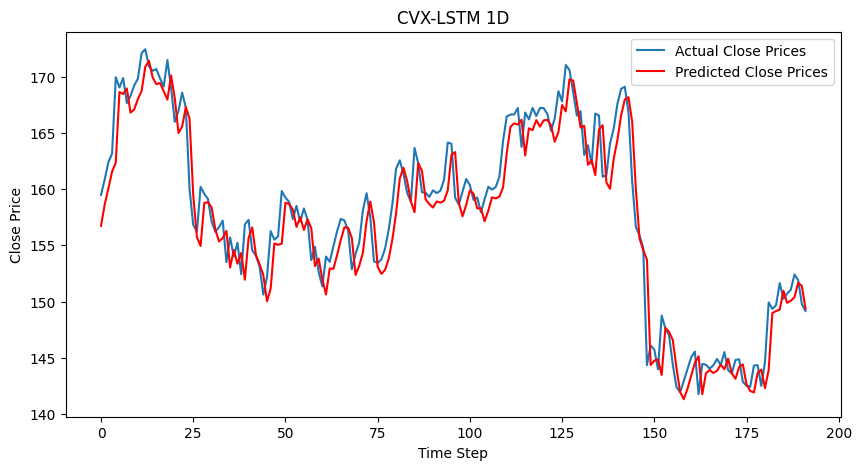

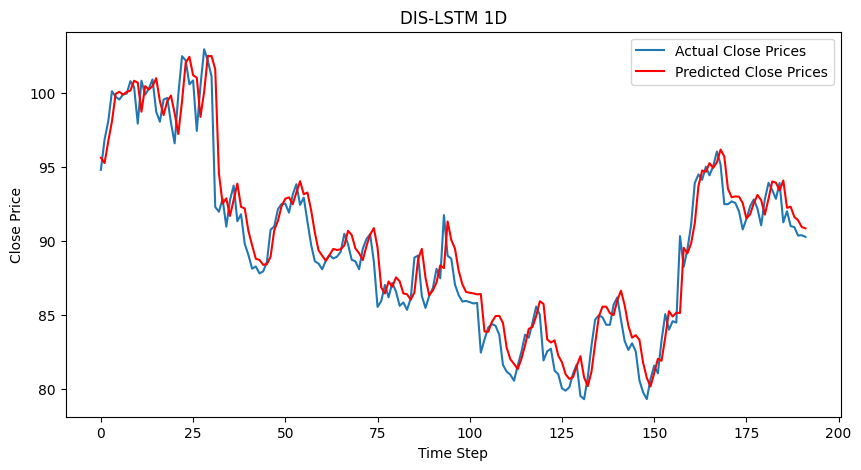

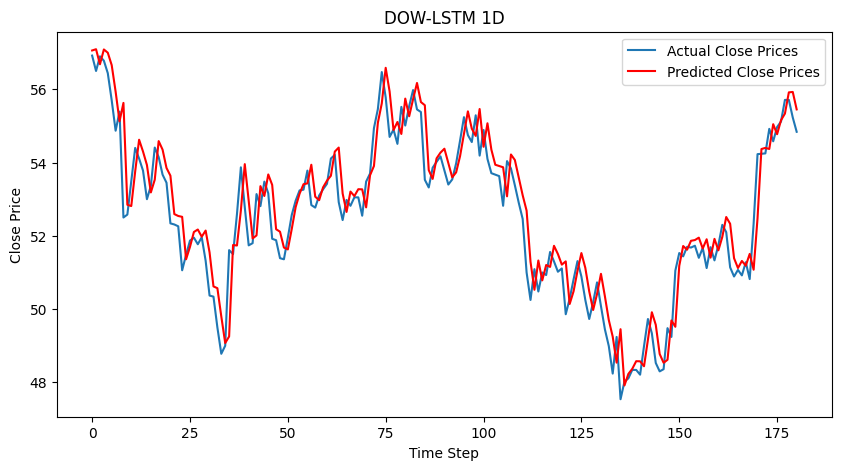

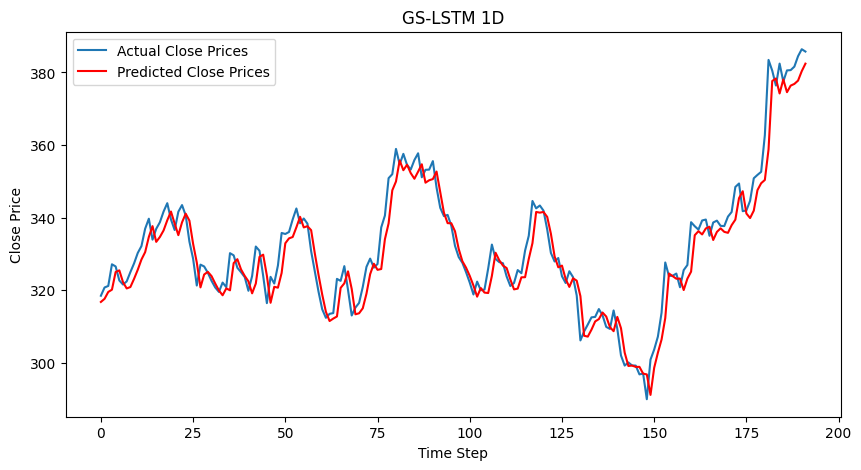

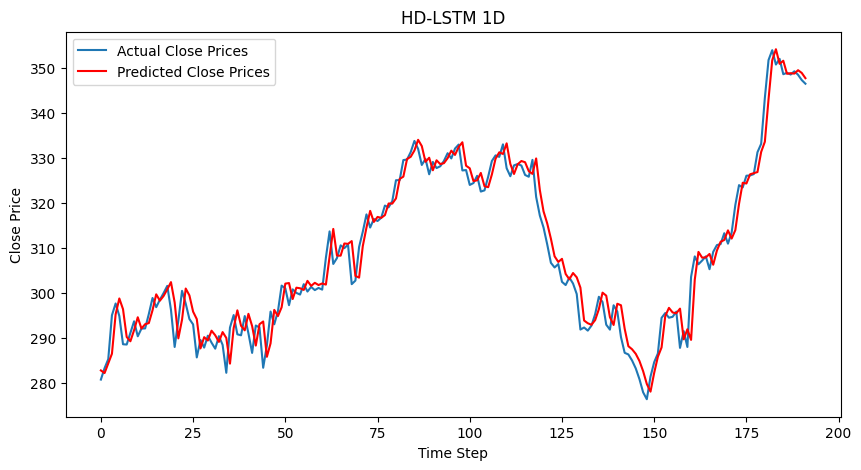

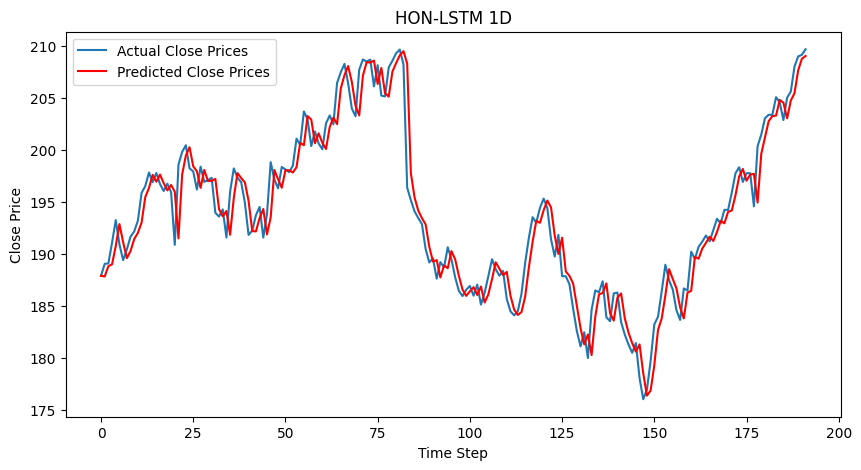

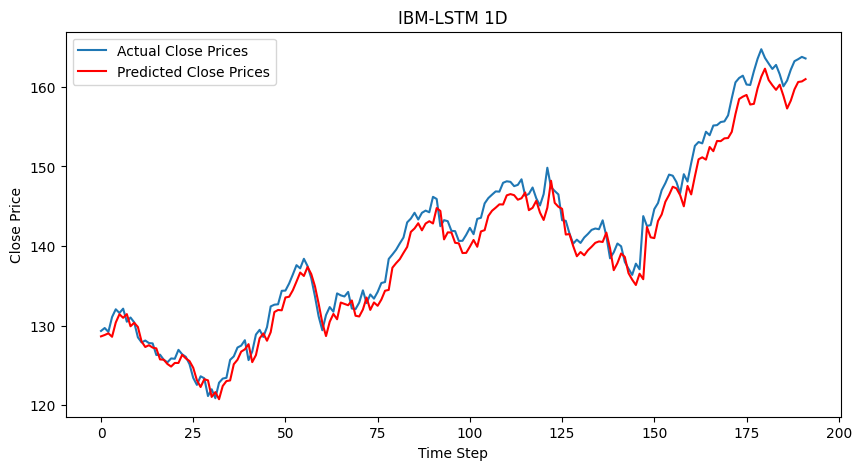

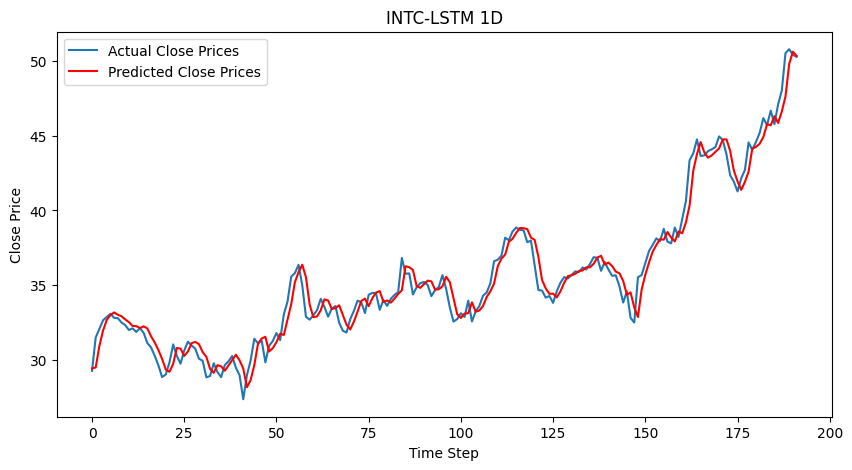

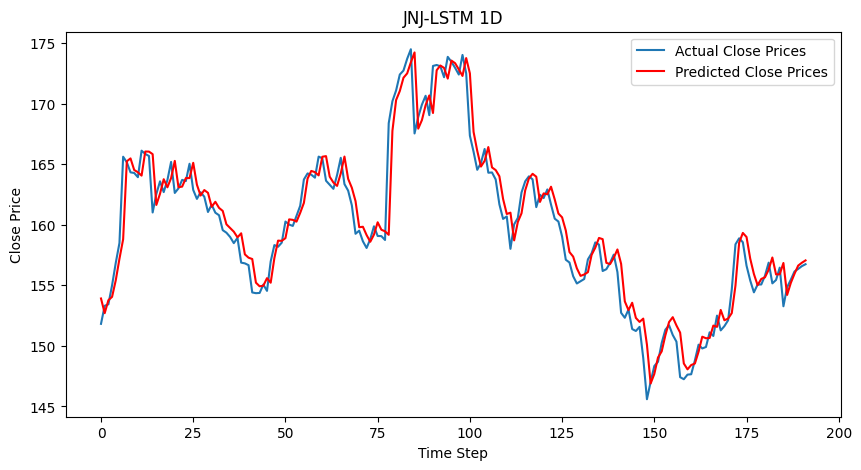

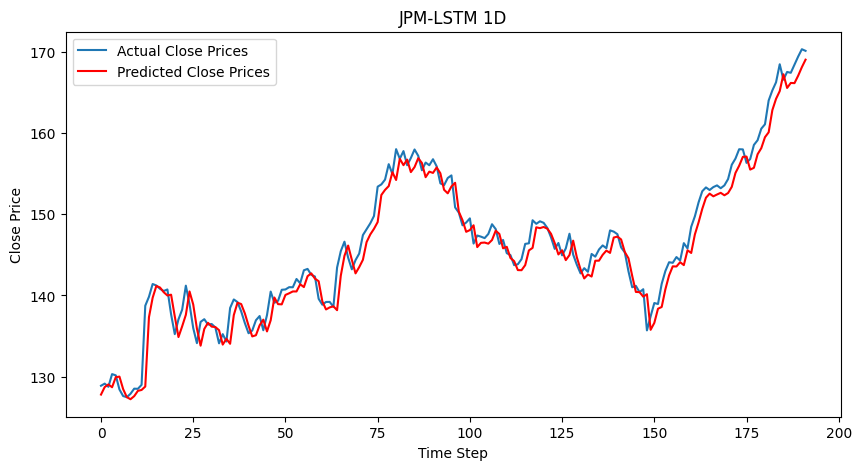

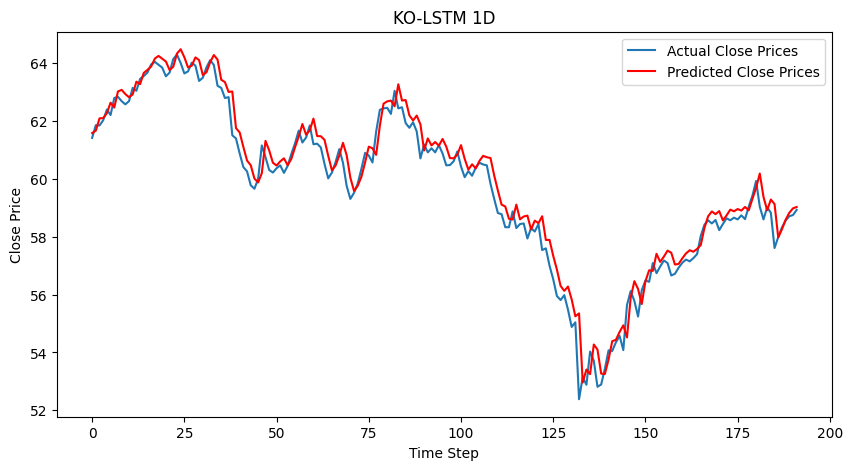

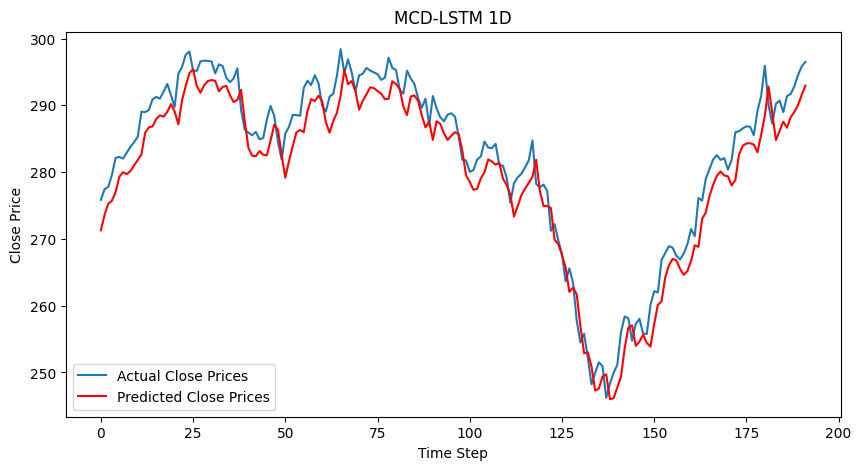

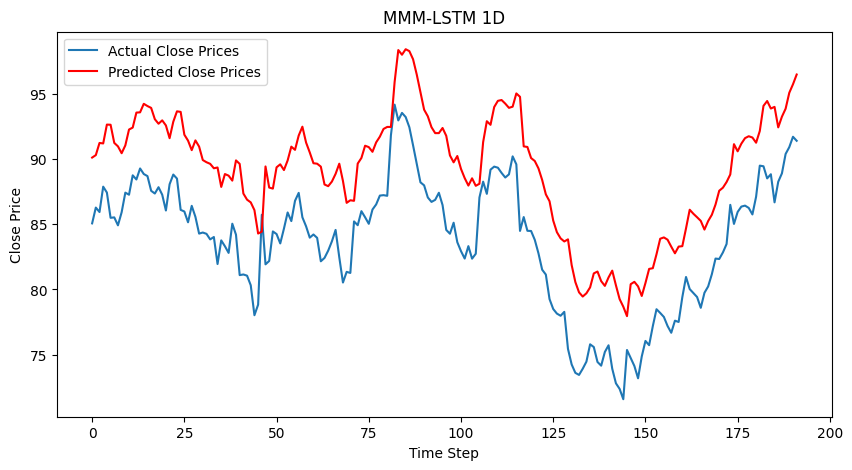

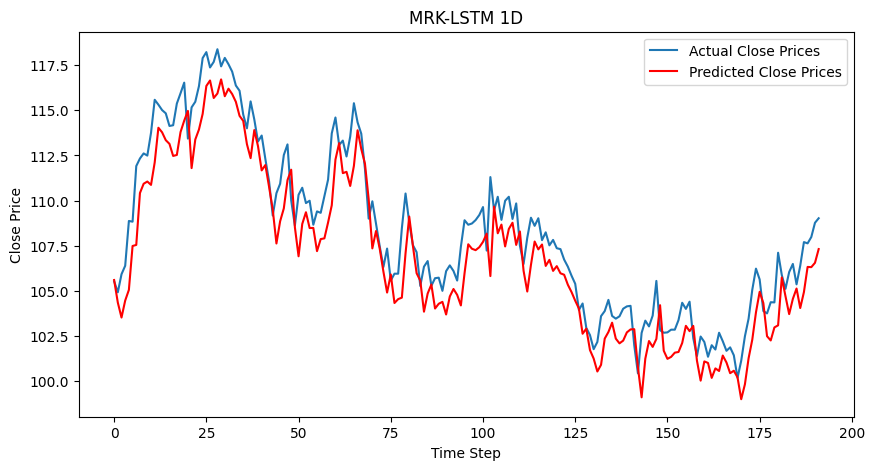

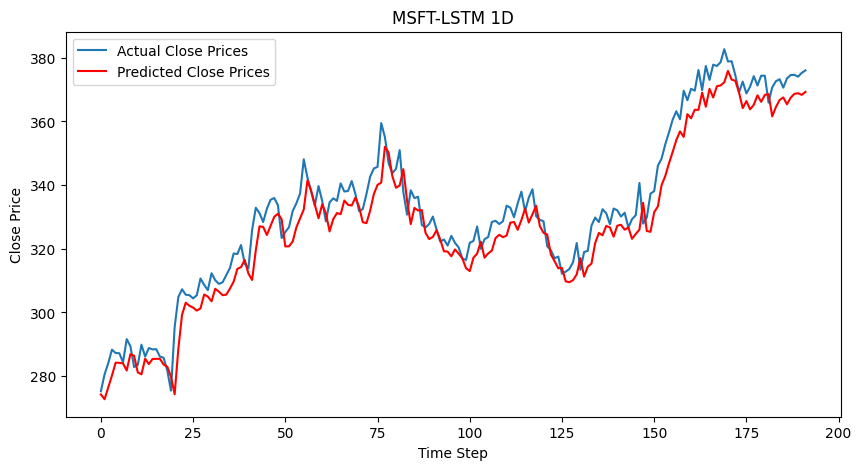

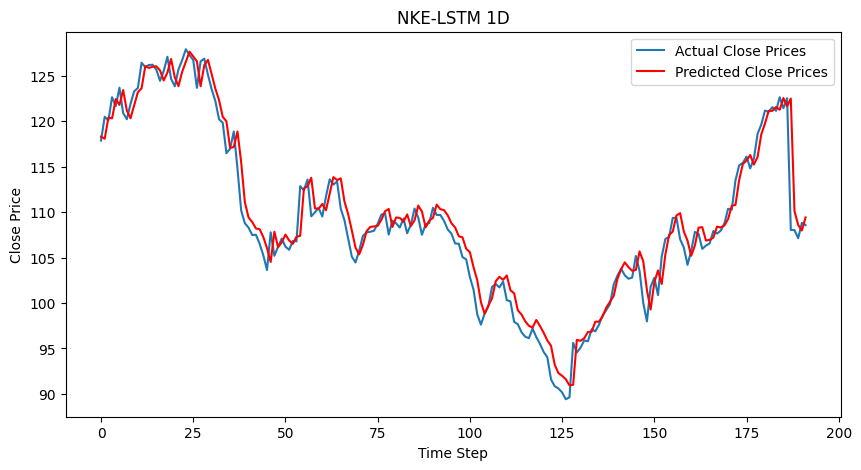

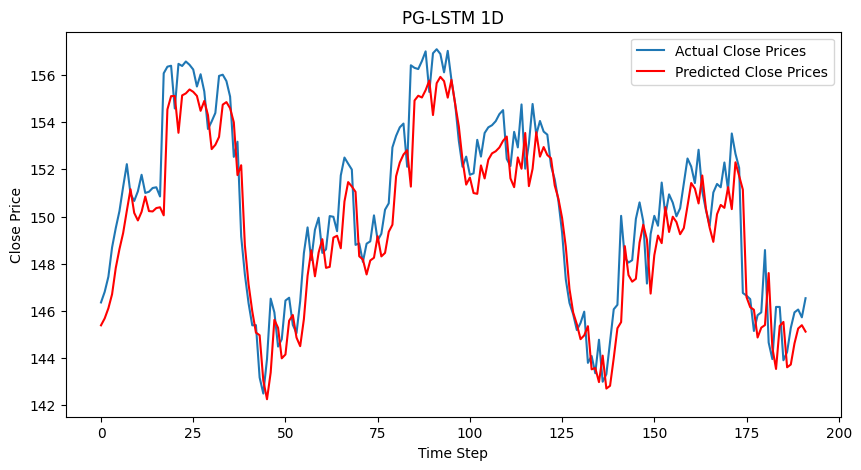

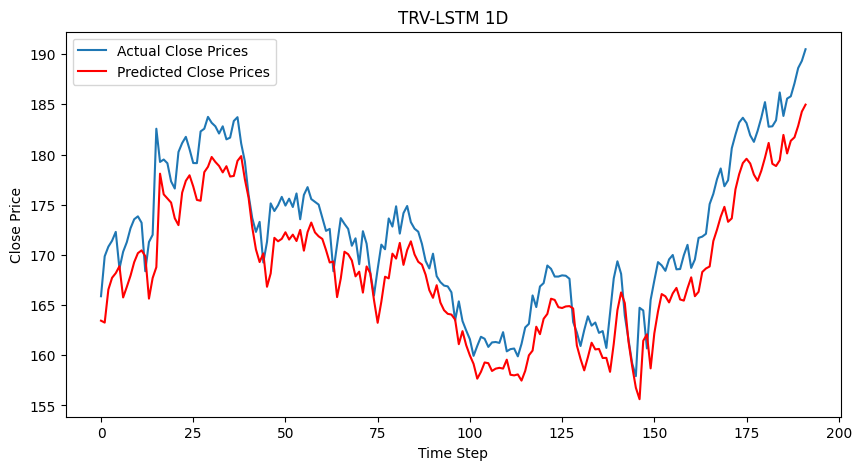

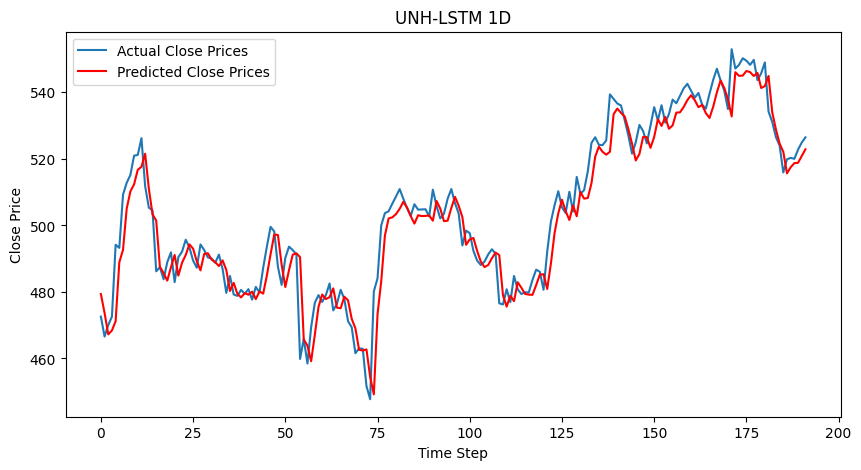

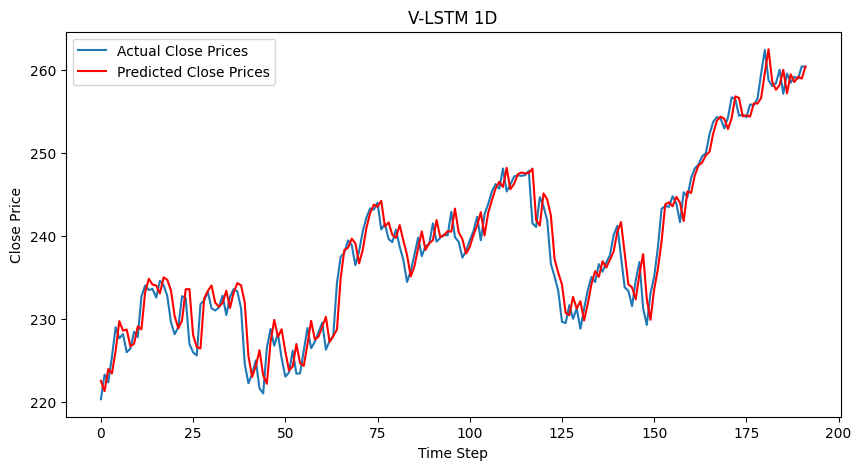

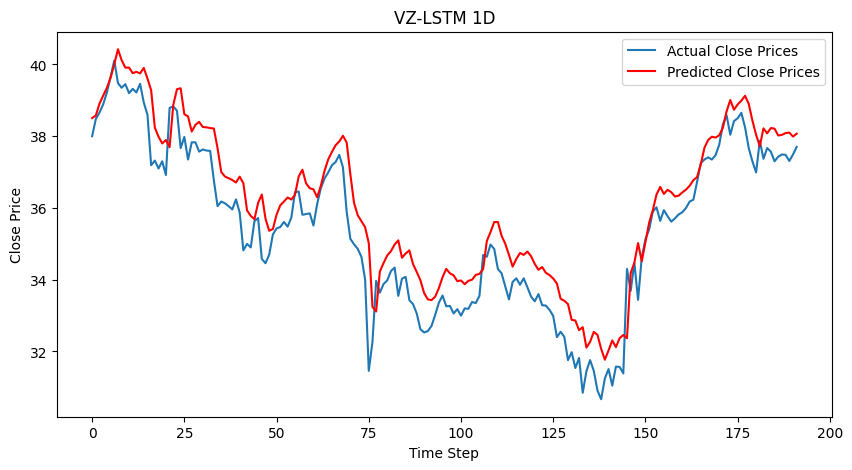

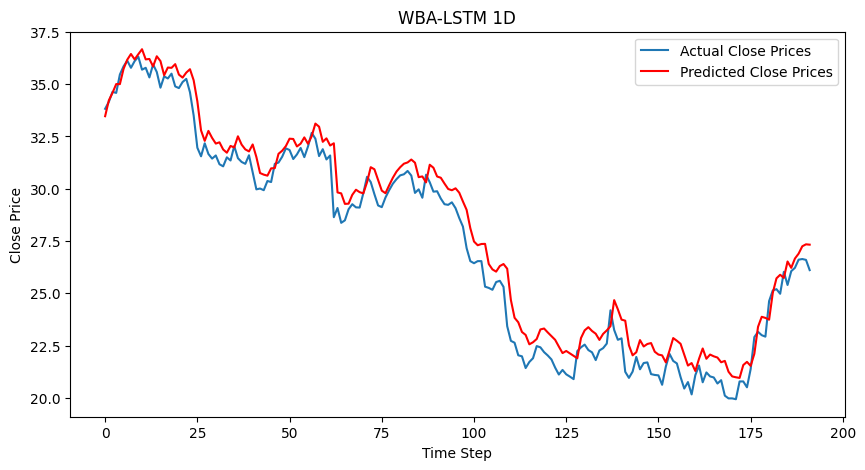

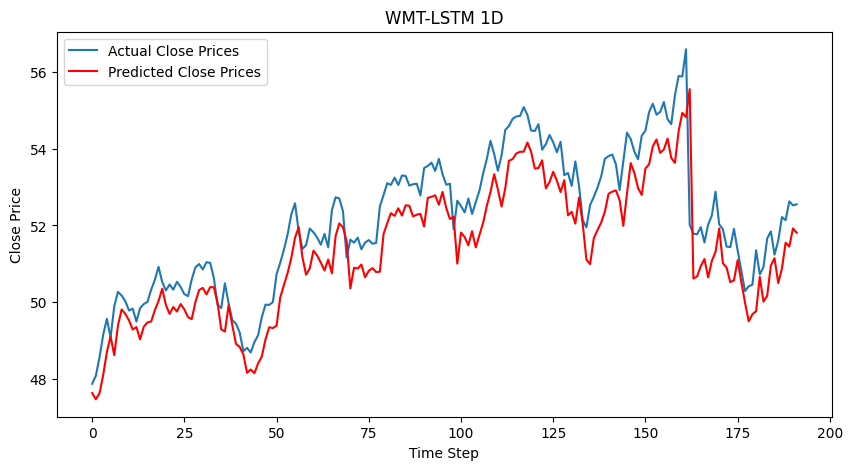

In [22]:
for stock in stock_list:
    stock_predict_1D(stock,stock)

In [23]:
!cd /kaggle/working
!zip -r lstm1d.zip /kaggle/working/lstm1d

  adding: kaggle/working/lstm1d/ (stored 0%)
  adding: kaggle/working/lstm1d/DOW_lstm1d.png (deflated 4%)
  adding: kaggle/working/lstm1d/CAT_lstm1d.keras (deflated 18%)
  adding: kaggle/working/lstm1d/GS_lstm1d.keras (deflated 19%)
  adding: kaggle/working/lstm1d/PG_lstm1d.png (deflated 4%)
  adding: kaggle/working/lstm1d/AMGN_lstm1d.png (deflated 6%)
  adding: kaggle/working/lstm1d/MRK_lstm1d.keras (deflated 19%)
  adding: kaggle/working/lstm1d/INTC_lstm1d.keras (deflated 19%)
  adding: kaggle/working/lstm1d/AXP_lstm1d.png (deflated 4%)
  adding: kaggle/working/lstm1d/KO_lstm1d.png (deflated 5%)
  adding: kaggle/working/lstm1d/DOW_lstm1d.keras (deflated 19%)
  adding: kaggle/working/lstm1d/BA_lstm1d.keras (deflated 19%)
  adding: kaggle/working/lstm1d/TRV_lstm1d.keras (deflated 18%)
  adding: kaggle/working/lstm1d/UNH_lstm1d.keras (deflated 19%)
  adding: kaggle/working/lstm1d/CSCO_lstm1d.keras (deflated 19%)
  adding: kaggle/working/lstm1d/CSCO_lstm1d.png (deflated 5%)
  adding: kag